In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [219]:
FN_df = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/model_comp/FN_comp.csv', names=['assay', 'FN_mcc'])
ST_df = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/model_comp/ST_comp.csv', names=['assay', 'ST_mcc'])
df_stats = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/assay_stats.csv')
df_chemical_descriptor = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/chemical_descriptor.csv')

#This one will need some different treatment
df_relations = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/assay_information.csv')
df_toxcast = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/Toxcast_aggregated.csv')
#Joining some other data together

comparison = FN_df.merge(ST_df, on = 'assay', how = 'inner')

In [220]:
comparison['method_difference'] = comparison['FN_mcc']-comparison['ST_mcc']

In [221]:
df_stats = df_stats.rename(columns={'assay_name':'assay'})
df_stats

Unnamed: 0                             assay  active_compounds  \
0             0           ACEA_T47D_80hr_Negative             424.0   
1             1           ACEA_T47D_80hr_Positive             279.0   
2             2  APR_HepG2_CellCycleArrest_24h_dn             167.0   
3             3  APR_HepG2_CellCycleArrest_24h_up              43.0   
4             4  APR_HepG2_CellCycleArrest_72h_dn             232.0   
..          ...                               ...               ...   
612         612         Tanguay_ZF_120hpf_SOMI_up              38.0   
613         613         Tanguay_ZF_120hpf_SWIM_up              32.0   
614         614         Tanguay_ZF_120hpf_TRUN_up              56.0   
615         615           Tanguay_ZF_120hpf_TR_up              80.0   
616         616          Tanguay_ZF_120hpf_YSE_up             125.0   

     inactive_compounds  missing_compounds   total  fraction_active  \
0                1233.0             6130.0  7787.0         0.054450   
1                1374.0             6134.0  7787.0         0.035829   
2                 834.0             6786.0  7787.0         0.021446   
3                 959.0             6785.0  7787.0         0.005522   
4                 766.0             6789.0  7787.0         0.029793   
..                  ...                ...     ...              ...   
612               953.0             6796.0  7787.0         0.004880   
613               958.0             6797.0  7787.0         0.004109   
614               934.0             6797.0  7787.0         0.007191   
615               911.0             6796.0  7787.0         0.010274   
616               866.0             6796.0  7787.0         0.016052   

     fraction_inactive  fraction_missing  
0             0.158341          0.787209  
1             0.176448          0.787723  
2             0.107102          0.871452  
3             0.123154          0.871324  
4             0.098369          0.871838  
..                 ...               ...  
612           0.122383          0.872737  
613           0.123026          0.872865  
614           0.119943          0.872865  
615           0.116990          0.872737  
616           0.111211          0.872737  

[617 rows x 9 columns]

In [222]:
comparison = comparison.merge(df_stats.loc[:,['assay', 'fraction_active', 'active_compounds','fraction_missing']], on = 'assay', how = 'inner')

In [289]:
max(comparison['method_difference'])

0.6910095504683748

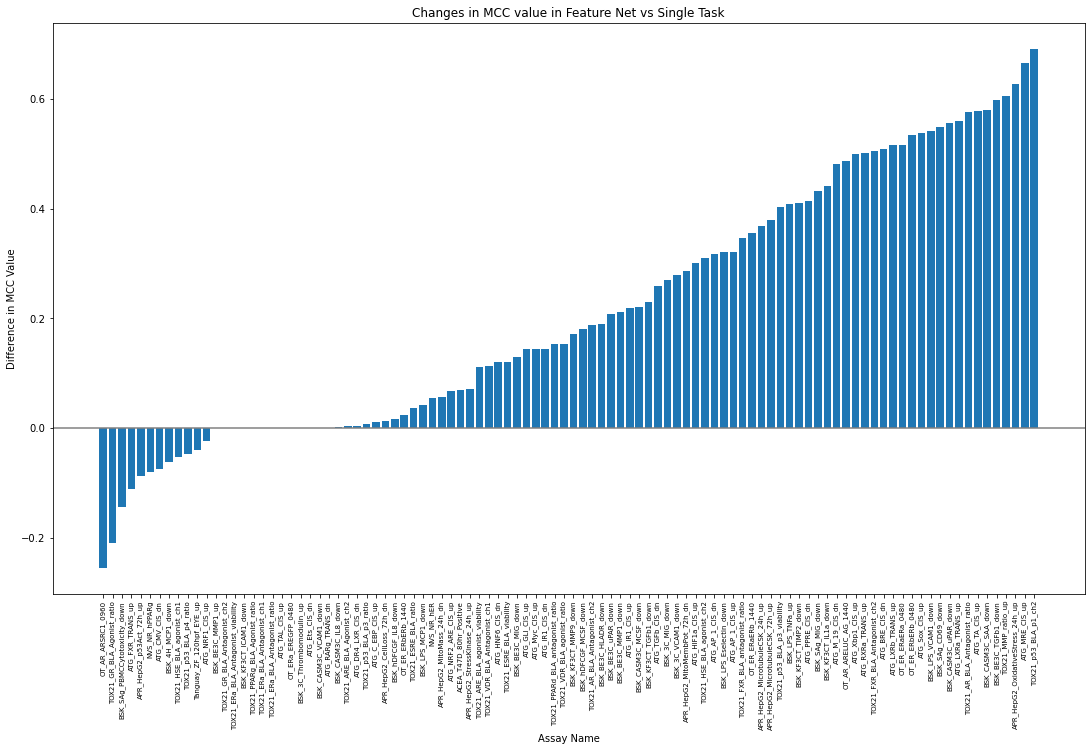

In [67]:
plt.bar(comparison['assay'],comparison['method_difference'].sort_values())
plt.xlabel('Assay Name')
plt.ylabel('Difference in MCC Value')
plt.title('Changes in MCC value in Feature Net vs Single Task')
plt.xticks(rotation=90, fontsize = '7')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.axhline(0, color='gray')

plt.savefig('/Users/Allen/Desktop/Dissertation/Moritz_notebook/model_comp/assay_comp.pdf', bbox_inches ='tight')


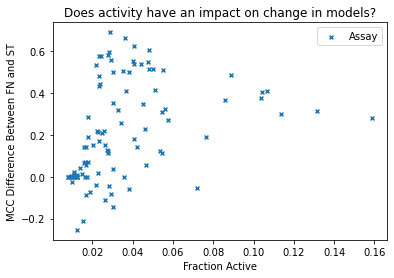

In [84]:

plt.scatter(comparison['fraction_active'],comparison['method_difference'],marker = 'x', s=15, label = 'Assay')
plt.xlabel('Fraction Active')
plt.ylabel('MCC Difference Between FN and ST')
plt.title('Does activity have an impact on change in models?')
plt.legend()
plt.show()

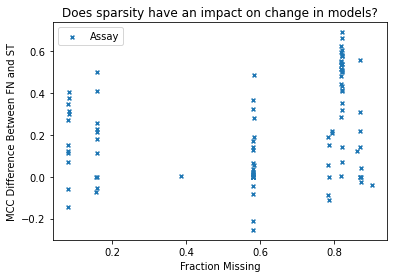

In [83]:
plt.scatter(comparison['fraction_missing'],comparison['method_difference'],marker = 'x', s=15, label = 'Assay')
plt.xlabel('Fraction Missing')
plt.ylabel('MCC Difference Between FN and ST')
plt.title('Does sparsity have an impact on change in models?')
plt.legend()
plt.show()

# Now using information theory stuff

In [93]:

del df_relations['Unnamed: 0']

In [223]:


#This funtion returns the contingency table between assay1 and assay2


def cont_table_assays(assay1,assay2):
    #get contigengency table that describes actives in assay1 and assay2
    #considers only substances measured in both assays
    #return 2x2 contingengy table: (0,0)/a: A+B+, (0,1)/b: A+B-, (1,0)/c: A-B+, (1,1)/d: A-B-
    
    a = 0
    b = 0
    c = 0
    d = 0
    
    for ass1,ass2 in zip(assay1,assay2):
        
        if math.isnan(ass1) or math.isnan(ass2): #consider only cases where compound was measured in both assyas
            continue
        
        if ass1 == 1 and ass2 == 1:
            a+=1
        
        elif ass1 == 1 and ass2 == 0:
            b+=1
        
        elif ass1 == 0 and ass2 == 1:
            c+=1
        
        elif ass1 == 0 and ass2 == 0:
            d+=1
            
    return(np.array([[a,b],[c,d]])) 



#This function uses the contingency table to compute information metrics

def info_metrics(array):
    a = array[0,0]
    b = array[0,1]
    c = array[1,0]
    d = array[1,1]
    
    #prob active in assay1
    p1 = (a+b)/(a+b+c+d)
    #entropy assay1
    h1 = -p1*np.log2(p1) - (1-p1)*np.log2(1-p1)
    
    #prob active in assay2
    p2 = (a+c)/(a+b+c+d)
    #entropy assay2
    h2 = -p2*np.log2(p2) - (1-p2)*np.log2(1-p2)
    
    #prob each table field
    p3 = a/(a+b+c+d)
    p4 = b/(a+b+c+d)
    p5 = c/(a+b+c+d)
    p6 = d/(a+b+c+d)
    
    #joint entropy
    h12 = -p3*np.log2(p3) - p4*np.log2(p4) - p5*np.log2(p5) - p6*np.log2(p6)
    
    #mutual information
    mi = h1 + h2 - h12
    
    return(h1,h2,h12,mi)

# Combining these two so the only output is the metric

from math import isnan
from numpy import log2

def metric_of_two(assay1,assay2):
    #get contigengency table that describes actives in assay1 and assay2
    #considers only substances measured in both assays
    #return 2x2 contingengy table: (0,0)/a: A+B+, (0,1)/b: A+B-, (1,0)/c: A-B+, (1,1)/d: A-B-
    
    a = 0
    b = 0
    c = 0
    d = 0
    
    for ass1,ass2 in zip(assay1,assay2):
        
        if isnan(ass1) or isnan(ass2): #consider only cases where compound was measured in both assyas
            continue
        
        if ass1 == 1 and ass2 == 1:
            a+=1
        
        elif ass1 == 1 and ass2 == 0:
            b+=1
        
        elif ass1 == 0 and ass2 == 1:
            c+=1
        
        elif ass1 == 0 and ass2 == 0:
            d+=1
    
    #prob active in assay1
    p1 = (a+b)/(a+b+c+d)
    #entropy assay1
    h1 = -p1*log2(p1) - (1-p1)*log2(1-p1)
    
    #prob active in assay2
    p2 = (a+c)/(a+b+c+d)
    #entropy assay2
    h2 = -p2*log2(p2) - (1-p2)*log2(1-p2)
    
    #prob each table field
    p3 = a/(a+b+c+d)
    p4 = b/(a+b+c+d)
    p5 = c/(a+b+c+d)
    p6 = d/(a+b+c+d)
    
    #joint entropy
    h12 = -p3*log2(p3) - p4*log2(p4) - p5*log2(p5) - p6*log2(p6)
    
    #mutual information
    mi = h1 + h2 - h12
    
    return(h12,mi)

#Creating lost of combinations
from itertools import combinations


header_list = list(comparison['assay'].tolist())
header_combinations = []

for combo in combinations(header_list, 2):  # 2 for pairs, 3 for triplets, etc
    header_combinations.append(combo)

header_combinations = np.array(header_combinations)


information_table = np.zeros([len(header_combinations), 2])

for i in range(len(header_combinations)): #iterate over combinations
        
    information_table[i,0], information_table[i,1] = metric_of_two(df_toxcast[header_combinations[i,0]],df_toxcast[header_combinations[i,1]])

df_relations = pd.DataFrame({'assay1' : header_combinations[:,0],
                           'assay2': header_combinations[:,1],
                           'joint_entropy' : information_table[:,0],
                           'mutual_information' : information_table[:,1]})


<ipython-input-223-f279c6836318>:121: RuntimeWarning: divide by zero encountered in log2
  h12 = -p3*log2(p3) - p4*log2(p4) - p5*log2(p5) - p6*log2(p6)
<ipython-input-223-f279c6836318>:121: RuntimeWarning: invalid value encountered in double_scalars
  h12 = -p3*log2(p3) - p4*log2(p4) - p5*log2(p5) - p6*log2(p6)


In [224]:
df_relations['ratio'] = df_relations['mutual_information']/df_relations['joint_entropy']

In [225]:
df_relations[((df_relations['assay1'] =='OT_AR_ARSRC1_0960') | (df_relations['assay2'] == 'OT_AR_ARSRC1_0960'))]


assay1                            assay2  joint_entropy  \
0   OT_AR_ARSRC1_0960        TOX21_GR_BLA_Agonist_ratio       0.853721   
1   OT_AR_ARSRC1_0960     BSK_SAg_PBMCCytotoxicity_down       1.266457   
2   OT_AR_ARSRC1_0960                  ATG_FXR_TRANS_up       0.745224   
3   OT_AR_ARSRC1_0960           APR_HepG2_p53Act_72h_up       1.277444   
4   OT_AR_ARSRC1_0960                     NVS_NR_hPPARg       1.407856   
..                ...                               ...            ...   
94  OT_AR_ARSRC1_0960               BSK_BE3C_TGFb1_down       1.146125   
95  OT_AR_ARSRC1_0960                TOX21_MMP_ratio_up       0.704620   
96  OT_AR_ARSRC1_0960  APR_HepG2_OxidativeStress_24h_up       1.315288   
97  OT_AR_ARSRC1_0960                    ATG_MRE_CIS_up       1.247356   
98  OT_AR_ARSRC1_0960              TOX21_p53_BLA_p1_ch2       0.813685   

    mutual_information     ratio  
0             0.013737  0.016091  
1             0.033858  0.026735  
2             0.005798  0.007781  
3             0.023349  0.018278  
4             0.000186  0.000132  
..                 ...       ...  
94            0.019748  0.017230  
95            0.000352  0.000499  
96            0.033952  0.025813  
97            0.078805  0.063178  
98            0.014239  0.017500  

[99 rows x 5 columns]

In [226]:
#finding the average mutual information in

list1 = []

for i in comparison['assay'].tolist():
    list1.append([i,df_relations['ratio'][((df_relations['assay1'] ==i) | (df_relations['assay2'] == i))].mean() ])
    

In [227]:
list1=np.array(list1)
df_1 = pd.DataFrame(list1, columns = ['assay', 'similarity'])
comparison = comparison.merge(df_1, on = 'assay', how = 'inner')
comparison['similarity'] = pd.to_numeric(comparison["similarity"], downcast="float")

In [228]:
comparison

assay    FN_mcc    ST_mcc  method_difference  \
0                  OT_AR_ARSRC1_0960  0.271606  0.382556          -0.110949   
1         TOX21_GR_BLA_Agonist_ratio  0.561356  0.440341           0.121014   
2      BSK_SAg_PBMCCytotoxicity_down  0.795711  0.240028           0.555683   
3                   ATG_FXR_TRANS_up  0.000000  0.000000           0.000000   
4            APR_HepG2_p53Act_72h_up  0.382117  0.162685           0.219432   
..                               ...       ...       ...                ...   
95               BSK_BE3C_TGFb1_down  0.767011  0.169853           0.597159   
96                TOX21_MMP_ratio_up  0.000000 -0.003648           0.003648   
97  APR_HepG2_OxidativeStress_24h_up  0.537000 -0.021904           0.558904   
98                    ATG_MRE_CIS_up  0.717065  0.230216           0.486849   
99              TOX21_p53_BLA_p1_ch2  0.420205  0.309125           0.111079   

    fraction_active  active_compounds  fraction_missing  similarity  
0          0.026198             204.0          0.786824    0.023897  
1          0.053422             416.0          0.080262    0.051755  
2          0.040195             313.0          0.820342    0.071654  
3          0.012585              98.0          0.581610    0.014473  
4          0.025684             200.0          0.871581    0.032000  
..              ...               ...               ...         ...  
95         0.028381             221.0          0.820342    0.061180  
96         0.011558              90.0          0.386285    0.003739  
97         0.029408             229.0          0.871709    0.051120  
98         0.088609             690.0          0.582381    0.041345  
99         0.054450             424.0          0.079620    0.019698  

[100 rows x 8 columns]

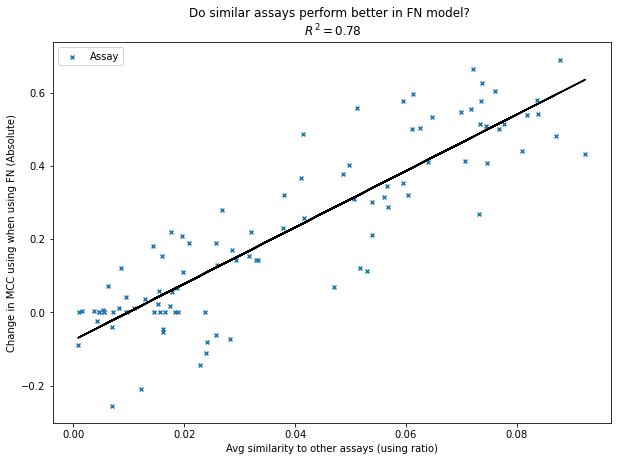

In [270]:
plt.scatter(comparison['similarity'], comparison['method_difference'],marker = 'x', s=15, label = 'Assay' )
plt.title('Do similar assays perform better in FN model? \n $R^2 = 0.78$')
plt.xlabel('Avg similarity to other assays (using ratio)')
plt.ylabel('Change in MCC using when using FN (Absolute)')
z = np.polyfit(comparison['similarity'], comparison['method_difference'], 1)
p = np.poly1d(z)
plt.plot(comparison['similarity'],p(comparison['similarity']),"black")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.savefig('/Users/Allen/Desktop/Dissertation/Moritz_notebook/model_comp/other_comp.pdf', bbox_inches ='tight')

plt.show()




In [247]:
import scipy.stats

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

rsquared(comparison['similarity'],comparison['method_difference'])

0.7781465008889145

In [271]:
df_train = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/df_train.csv')

In [272]:
df_train

Unnamed: 0                 standardised_smiles  OT_AR_ARSRC1_0960  \
0              0                           BrC(Br)Br                NaN   
1              1                  BrC(Br)C(Br)(Br)Br                NaN   
2              2                      BrC(Br)C(Br)Br                NaN   
3              3                         BrC/C=C/CBr                NaN   
4              4  BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br                1.0   
...          ...                                 ...                ...   
7782        7782                   c1coc(Cn2cccc2)c1                NaN   
7783        7783         c1csc(-c2ccc(-c3cccs3)s2)c1                NaN   
7784        7784         c1csc(C2(N3CCCCC3)CCCCC2)c1                NaN   
7785        7785                  c1csc(SSc2cccs2)c1                NaN   
7786        7786                          c1nc[nH]n1                NaN   

      TOX21_GR_BLA_Agonist_ratio  BSK_SAg_PBMCCytotoxicity_down  \
0                            0.0                            NaN   
1                            0.0                            NaN   
2                            0.0                            NaN   
3                            0.0                            NaN   
4                            1.0                            1.0   
...                          ...                            ...   
7782                         0.0                            NaN   
7783                         1.0                            NaN   
7784                         0.0                            NaN   
7785                         0.0                            NaN   
7786                         0.0                            NaN   

      ATG_FXR_TRANS_up  APR_HepG2_p53Act_72h_up  NVS_NR_hPPARg  \
0                  NaN                      NaN            NaN   
1                  NaN                      NaN            NaN   
2                  NaN                      NaN            NaN   
3                  NaN                      NaN            NaN   
4                  1.0                      NaN            0.0   
...                ...                      ...            ...   
7782               NaN                      NaN            NaN   
7783               0.0                      NaN            NaN   
7784               NaN                      NaN            NaN   
7785               NaN                      NaN            NaN   
7786               0.0                      NaN            0.0   

      ATG_CMV_CIS_dn  BSK_4H_MCP1_down  ...  BSK_CASM3C_uPAR_down  \
0                NaN               NaN  ...                   NaN   
1                NaN               NaN  ...                   NaN   
2                NaN               NaN  ...                   NaN   
3                NaN               NaN  ...                   NaN   
4                0.0               1.0  ...                   0.0   
...              ...               ...  ...                   ...   
7782             NaN               NaN  ...                   NaN   
7783             0.0               NaN  ...                   NaN   
7784             NaN               NaN  ...                   NaN   
7785             NaN               NaN  ...                   NaN   
7786             0.0               0.0  ...                   0.0   

      ATG_LXRa_TRANS_up  TOX21_AR_BLA_Antagonist_ratio  ATG_TA_CIS_up  \
0                   NaN                            0.0            NaN   
1                   NaN                            1.0            NaN   
2                   NaN                            0.0            NaN   
3                   NaN                            0.0            NaN   
4                   0.0                            1.0            0.0   
...                 ...                            ...            ...   
7782                NaN                            0.0            NaN   
7783                0.0                            0.0            1.0   
7784                N

<ipython-input-223-f279c6836318>:121: RuntimeWarning: divide by zero encountered in log2
  h12 = -p3*log2(p3) - p4*log2(p4) - p5*log2(p5) - p6*log2(p6)
<ipython-input-223-f279c6836318>:121: RuntimeWarning: invalid value encountered in double_scalars
  h12 = -p3*log2(p3) - p4*log2(p4) - p5*log2(p5) - p6*log2(p6)


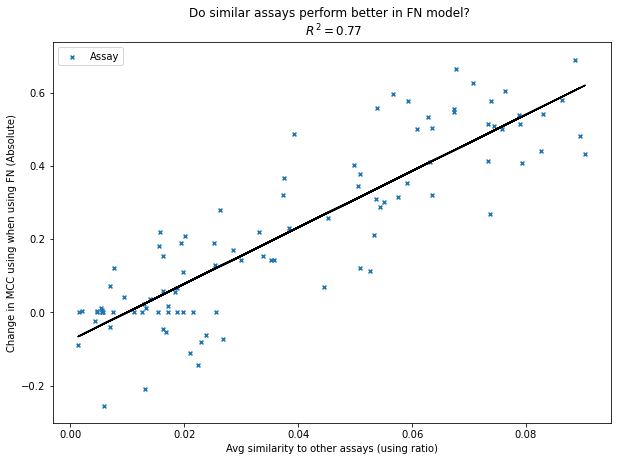

0.7681950278492851


In [286]:
#Creating lost of combinations
from itertools import combinations

df_train = pd.read_csv('/Users/Allen/Desktop/Dissertation/Moritz_notebook/df_train.csv')
del df_train['standardised_smiles']
del df_train['Unnamed: 0']


header_list = df_train.columns.tolist()
header_combinations = []

for combo in combinations(header_list, 2):  # 2 for pairs, 3 for triplets, etc
    header_combinations.append(combo)

header_combinations = np.array(header_combinations)


information_table = np.zeros([len(header_combinations), 2])

for i in range(len(header_combinations)): #iterate over combinations
        
    information_table[i,0], information_table[i,1] = metric_of_two(df_train[header_combinations[i,0]],df_train[header_combinations[i,1]])

df_relations = pd.DataFrame({'assay1' : header_combinations[:,0],
                           'assay2': header_combinations[:,1],
                           'joint_entropy' : information_table[:,0],
                           'mutual_information' : information_table[:,1]})


df_relations['ratio'] = df_relations['mutual_information']/df_relations['joint_entropy']

list1 = []

for i in comparison['assay'].tolist():
    list1.append([i,df_relations['ratio'][((df_relations['assay1'] ==i) | (df_relations['assay2'] == i))].mean() ])
    
list1=np.array(list1)
df_1 = pd.DataFrame(list1, columns = ['assay', 'similarity'])
comparison = comparison.merge(df_1, on = 'assay', how = 'inner')
comparison['similarity'] = pd.to_numeric(comparison["similarity"], downcast="float")

plt.scatter(comparison['similarity'], comparison['method_difference'],marker = 'x', s=15, label = 'Assay' )
plt.title('Do similar assays perform better in FN model? \n $R^2 = 0.77$')
plt.xlabel('Avg similarity to other assays (using ratio)')
plt.ylabel('Change in MCC using when using FN (Absolute)')
z = np.polyfit(comparison['similarity'], comparison['method_difference'], 1)
p = np.poly1d(z)
plt.plot(comparison['similarity'],p(comparison['similarity']),"black")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.savefig('/Users/Allen/Desktop/Dissertation/Moritz_notebook/model_comp/other_comp_train.pdf', bbox_inches ='tight')

plt.show()


print(rsquared(comparison['similarity'],comparison['method_difference']))